In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
options = Options()
# Запуск браузера с развернутым экраном
options.add_argument('start-maximized')
# Будем использовать браузер Chrom
driver = webdriver.Chrome(options=options)
# Открываем ссылку
driver.get('https://www.wildberries.ru/')
time.sleep(4)

In [3]:
wait = WebDriverWait(driver, 10)
# Ищем строку поиска
input = wait.until(EC.presence_of_element_located((By.ID, "searchInput")))
# Вводим фразу поиска и нажимаем Enter
input.send_keys('аккумулятор для ибп 12v')
input.send_keys(Keys.ENTER)

Прокручиваем страницу и записываем все ссылки на аккумуляторы, если есть кнопка "далее" - нажимаем её или выходим из цикла

In [4]:
# Список ссылок на страницы аккумулятора
url_list = []

while True:
    # Количество аккумуляторов на странице
    count = None
    while True:
        time.sleep(4)
        # Ожидаем появление объекта (html код) карточек товара
        cards = wait.until(EC.presence_of_all_elements_located((By.XPATH, '//article[@id]')))
        # Выходим из цикла, если при прокрутке страницы, количество товаров не меняется 
        if len(cards) == count:
            break    
        # Вычисляем сколько карточек товара на странице
        count = len(cards)
        # Прокручиваем страницу выполняя JAVA Script
        driver.execute_script('window.scrollBy(0, 1800)')
        time.sleep(2)
        
    # На полностью загруженной странице соберём инфу
    for card in cards:
        # Записываем ссылку каждого аккумулятора
        url = card.find_element(By.XPATH, './div/a').get_attribute('href')
        url_list.append(url)
    
    # Проверяем есть ли кнопка дальше
    try:
        next = driver.find_element(By.XPATH,  "//a[@class='pagination-next pagination__next j-next-page']")
        next.click()
    except Exception:
        break

In [5]:
print(f'Всего получено: {len(url_list)} ссылок на аккумуляторы')

Всего получено: 860 ссылок на аккумуляторы


Заходим на каждую страницу найденныж аккомуляторов и парсим её

In [6]:
driver2 = webdriver.Chrome(options=options)
wait2 = WebDriverWait(driver2, 10)
acb_list = []

# Просматриваем все ссылки ан аккумуляторы
for url_item in url_list:
    acb_dict = {}
    
    driver2.get(url_item)
    # Заносим назание аккумулятора
    acb_dict['name'] = wait2.until(EC.presence_of_element_located((By.XPATH, "//h1"))).text
    # Заносим цену аккумулятора
    price = wait2.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'price-block__wallet-price')))
    try:
        acb_dict['price'] = float(re.sub(r'[^\d.]+', '', price[1].text))
    except Exception:
        acb_dict['price'] = None
    # Заносим бренд аккумулятора
    acb_dict['brend'] = wait2.until(EC.presence_of_element_located((By.CLASS_NAME, "product-page__header-brand"))).text
    # Заносим url ссылку на аккумулятор
    acb_dict['url'] = url_item   
    
    # Обрабатываем табличные данные
    table_label = wait2.until(EC.presence_of_all_elements_located((By.XPATH, '//th')))
    table_param = wait2.until(EC.presence_of_all_elements_located((By.XPATH, '//td')))
    # Заносим данные в зависимости от названия   
    for i in range(len(table_label)):
        if table_label[i].text == 'Страна производства':
            acb_dict['country'] = table_param[i].text
        elif table_label[i].text == 'Емкость аккумулятора (Ач)':
            try:
                val = table_param[i].text.strip()
                val, *_ = val.split()
                acb_dict['capacity'] = float(re.sub(r'[^\d.]+', '', val))
            except Exception:
                acb_dict['capacity'] = None
        elif table_label[i].text == 'Напряжение':
             try:
                val = table_param[i].text.strip()
                val, *_ = val.split() 
                acb_dict['voltage'] = float(re.sub(r'[^\d.]+', '', val))
             except Exception:
                acb_dict['voltage'] = None
        
    # Добавляем словарь в список аккумуляторов
    acb_list.append(acb_dict)

TimeoutException: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF781757032+63090]
	(No symbol) [0x00007FF7816C2C82]
	(No symbol) [0x00007FF78155EC65]
	(No symbol) [0x00007FF7815A499D]
	(No symbol) [0x00007FF7815A4ADC]
	(No symbol) [0x00007FF7815E5B37]
	(No symbol) [0x00007FF7815C701F]
	(No symbol) [0x00007FF7815E3412]
	(No symbol) [0x00007FF7815C6D83]
	(No symbol) [0x00007FF7815983A8]
	(No symbol) [0x00007FF781599441]
	GetHandleVerifier [0x00007FF781B525AD+4238317]
	GetHandleVerifier [0x00007FF781B8F70D+4488525]
	GetHandleVerifier [0x00007FF781B879EF+4456495]
	GetHandleVerifier [0x00007FF781830576+953270]
	(No symbol) [0x00007FF7816CE54F]
	(No symbol) [0x00007FF7816C9224]
	(No symbol) [0x00007FF7816C935B]
	(No symbol) [0x00007FF7816B9B94]
	BaseThreadInitThunk [0x00007FFD4F7B7344+20]
	RtlUserThreadStart [0x00007FFD4FB826B1+33]


In [7]:
print(f'Обработано {len(acb_list)} страниц')

Обработано 317 страниц


Посмотрим, что за данные мы получили

In [8]:
df = pd.DataFrame(acb_list)
df.head()

,name,price,brend,url,voltage,country,capacity
0,Аккумулятор 12v 7ah акб agm 1207,None,SKAT,https://www.wildberries.ru/catalog/149737382/d...,12.00,Китай,7.00
1,"Аккумулятор SF 1212, 12Ач, аккумуляторная бата...",None,Security Force,https://www.wildberries.ru/catalog/45502816/de...,12.00,Китай,12.00
2,"Аккумулятор SF 1207, 7Ач, аккумуляторная батар...",None,Security Force,https://www.wildberries.ru/catalog/40724205/de...,12.00,Китай,7.00
3,Аккумулятор для ибп 12v 7 Ah F1/T1 осветительн...,None,Thomas,https://www.wildberries.ru/catalog/166716193/d...,12.00,Китай,7.00
4,Аккумулятор ибп 12v 7.5 Ah F2/T2 детской машин...,None,NPP,https://www.wildberries.ru/catalog/166716200/d...,12.00,Китай,7.50


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      317 non-null    object 
 1   price     0 non-null      object 
 2   brend     317 non-null    object 
 3   url       317 non-null    object 
 4   voltage   286 non-null    float64
 5   country   295 non-null    object 
 6   capacity  289 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.5+ KB


Какие производители аккумуляторов для ИБП представлены на Wildberries

In [10]:
data = df['country'].value_counts()
names = data.index
values = data.values
data

country
Китай      276
Вьетнам     16
Тайвань      3
Name: count, dtype: int64

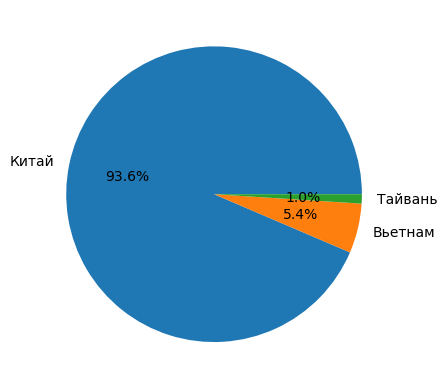

In [11]:
plt.pie(values, autopct='%.1f%%', labels=names)
plt.show()

In [12]:
df.to_csv('df.csv')